In [1]:
import pickle
import numpy as np
import time,sys,glob,os
import pandas as pd
import scipy.ndimage as ndi
import cc3d
import cv2
import open3d as o3d

from skimage import color, morphology, measure
from skimage.transform import downscale_local_mean
from skimage.registration import phase_cross_correlation

from scipy.stats import zscore
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from functions.cellregister import *
from functions.iterive_non_rigid import *
# from functions.tiling import *
import functions.tiling as tiling  # 如果tiling.py在同一个functions目录下

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
add_edge = np.array((10,100,100))
outputshape = add_edge*2

max_iteration = 100  # shape ICP max iteration 
thre = 8 # shape ICP parametrs
ds_sz = 5 # shape ICP downsample size
with_scaling = True # shape ICP learn the scaling 
ds_sz_aff=3 # NCC downsample size
vec_ds = 3 # vector field downsample size. 
max_correspondence_distance = 50

### 加载

In [3]:
def load_and_extract_matches(lut_path):
    """Load LUT and extract matched coordinates and images"""
    with open(lut_path, 'rb') as f:
        lookup_table = pickle.load(f)
    
    # Get images
    invivo_image = lookup_table['in_vivo']['Transformed']
    exvivo_image = lookup_table['exvivo_GCAMP']['Transformed']
    
    # Extract matched coordinates
    in_vivo_coords = []
    ex_vivo_coords = []
    
    for ex_cell in lookup_table['exvivo_GCAMP']['cells']:
        if 'in_vivo_id' in ex_cell:
            # Find matching in vivo cell
            in_vivo_cell = next(cell for cell in lookup_table['in_vivo']['cells'] 
                               if cell['id'] == ex_cell['in_vivo_id'])
            in_vivo_coords.append(in_vivo_cell['coordinates'])
            ex_vivo_coords.append(ex_cell['coordinates'])
    
    return (np.array(in_vivo_coords), np.array(ex_vivo_coords), 
            invivo_image, exvivo_image)


In [4]:
lut_path = "/scratch/jl10897/multimodal_image_registration/datasets/LUT_multimodal_487_Region2.pkl"
in_vivo_coords = load_and_extract_matches(lut_path)[0]
ex_vivo_coords = load_and_extract_matches(lut_path)[1]
invivo_image = load_and_extract_matches(lut_path)[2]
exvivo_image = load_and_extract_matches(lut_path)[3]

In [5]:
output_folder = os.path.join('/scratch/jl10897/multimodal_image_registration/output', os.path.basename(lut_path).replace('.pkl', ''))
print(output_folder)
os.makedirs(output_folder, exist_ok=True)

/scratch/jl10897/multimodal_image_registration/output/LUT_multimodal_487_Region2


In [6]:
with open(lut_path, 'rb') as f:
    lookup_table = pickle.load(f)

In [7]:
# Check coordinate order
print("First few in_vivo coordinates:")
print(in_vivo_coords[:3])
print("\nFirst few ex_vivo coordinates:")
print(ex_vivo_coords[:3])

# Print axis ranges
print("\nIn Ranges:")
print("in_vivo z:", in_vivo_coords[:,0].min(), "-", in_vivo_coords[:,0].max())
print("in_vivo x:", in_vivo_coords[:,1].min(), "-", in_vivo_coords[:,1].max()) 
print("in_vivo y:", in_vivo_coords[:,2].min(), "-", in_vivo_coords[:,2].max())

print("\nEx Ranges:")
print("ex_vivo z:", ex_vivo_coords[:,0].min(), "-", ex_vivo_coords[:,0].max())
print("ex_vivo x:", ex_vivo_coords[:,1].min(), "-", ex_vivo_coords[:,1].max()) 
print("ex_vivo y:", ex_vivo_coords[:,2].min(), "-", ex_vivo_coords[:,2].max())

First few in_vivo coordinates:
[[ 10.         222.03079473  51.28710104]
 [ 10.         264.07720707  52.93597996]
 [ 10.         271.90938192  76.84472423]]

First few ex_vivo coordinates:
[[   0.         1091.1953964  1234.3254837 ]
 [   0.         1264.10414196 1210.08593993]
 [   0.         1286.93875721 1315.5115125 ]]

In Ranges:
in_vivo z: 9.0 - 21.0
in_vivo x: 142.1661348825179 - 396.09293707718075
in_vivo y: 51.28710104243543 - 399.4058442561061

Ex Ranges:
ex_vivo z: 0.0 - 1.0
ex_vivo x: 835.2207981932627 - 1883.0714799233083
ex_vivo y: 1210.085939926042 - 2524.552165582886


In [8]:
# Count the number of cells in in-vivo and ex-vivo datasets
num_in_vivo_cells = len(lookup_table['in_vivo']['cells'])
num_ex_vivo_cells = len(lookup_table['exvivo_GCAMP']['cells'])

print(f"Number of in-vivo cells: {num_in_vivo_cells}")
print(f"Number of ex-vivo cells: {num_ex_vivo_cells}")


Number of in-vivo cells: 37
Number of ex-vivo cells: 37


缩放

In [9]:
from scipy.ndimage import zoom

# 计算缩放因子
scale_factors = [
    (ex_vivo_coords[:, i].max() - ex_vivo_coords[:, i].min()) /
    (in_vivo_coords[:, i].max() - in_vivo_coords[:, i].min())
    for i in range(3)
]

# 打印缩放因子以检查
print("Scale factors (z, x, y):", scale_factors)

# 对 in-vivo 坐标进行缩放
scaled_in_vivo_coords = in_vivo_coords.copy()
for i in range(3):
    scaled_in_vivo_coords[:, i] *= scale_factors[i]

# 对图像进行缩放
scaled_invivo_image = zoom(invivo_image, scale_factors, order=3)  # order=3 表示三次插值
print("Scaled in-vivo image shape:", scaled_invivo_image.shape)

# 打印缩放后的范围
print("\nScaled in-vivo coordinates:")
print(f"z: {scaled_in_vivo_coords[:,0].min()} - {scaled_in_vivo_coords[:,0].max()}")
print(f"x: {scaled_in_vivo_coords[:,1].min()} - {scaled_in_vivo_coords[:,1].max()}")
print(f"y: {scaled_in_vivo_coords[:,2].min()} - {scaled_in_vivo_coords[:,2].max()}")


Scale factors (z, x, y): [0.08333333333333333, 4.126585585584434, 3.775913395303861]
Scaled in-vivo image shape: (3, 1820, 1609)

Scaled in-vivo coordinates:
z: 0.75 - 1.75
x: 586.6607229644507 - 1634.5114046944962
y: 193.65565183243456 - 1508.1218774892786


可视化

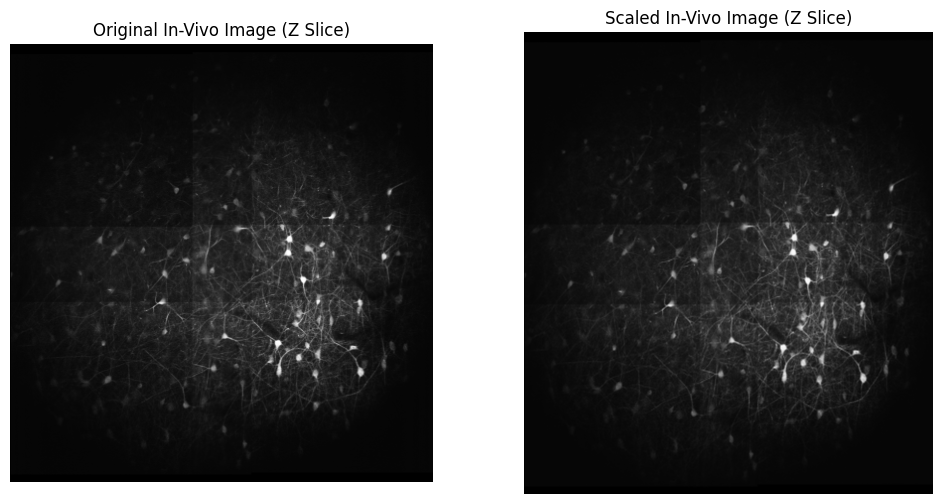

In [10]:
import matplotlib.pyplot as plt

# 可视化缩放前后的图像切片
z_slice = invivo_image.shape[0] // 2  # 原图 z 轴中间切片
scaled_z_slice = scaled_invivo_image.shape[0] // 2  # 缩放后 z 轴中间切片

# 绘制对比图
plt.figure(figsize=(12, 6))

# 原始图像切片
plt.subplot(1, 2, 1)
plt.imshow(invivo_image[z_slice, :, :], cmap='gray')
plt.title("Original In-Vivo Image (Z Slice)")
plt.axis('off')

# 缩放后的图像切片
plt.subplot(1, 2, 2)
plt.imshow(scaled_invivo_image[scaled_z_slice, :, :], cmap='gray')
plt.title("Scaled In-Vivo Image (Z Slice)")
plt.axis('off')

plt.show()


Segmentation 1

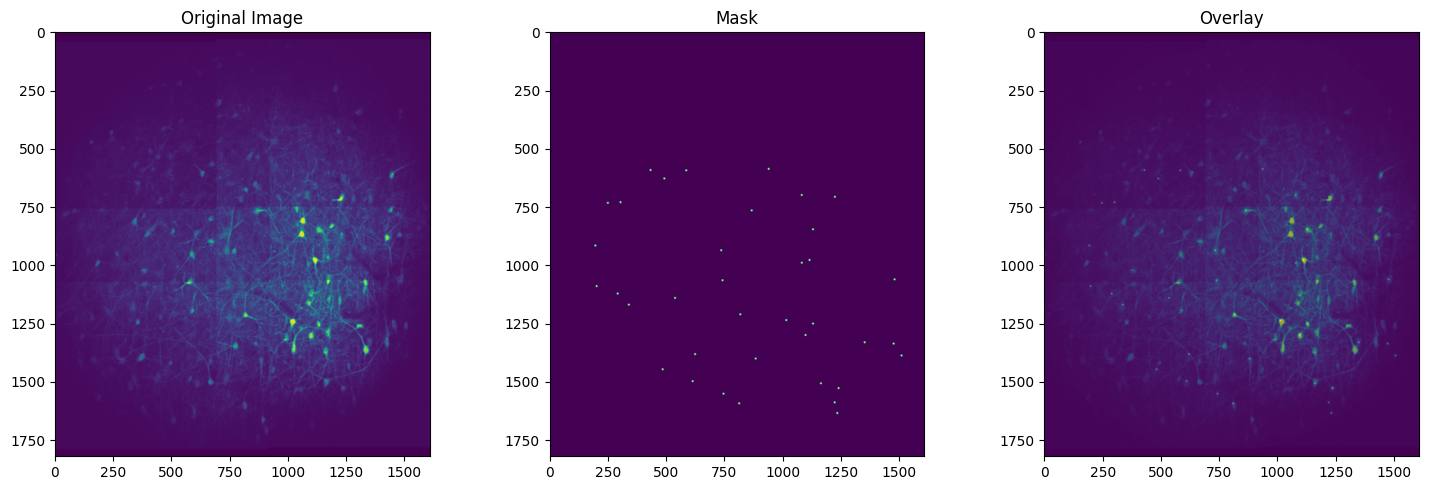

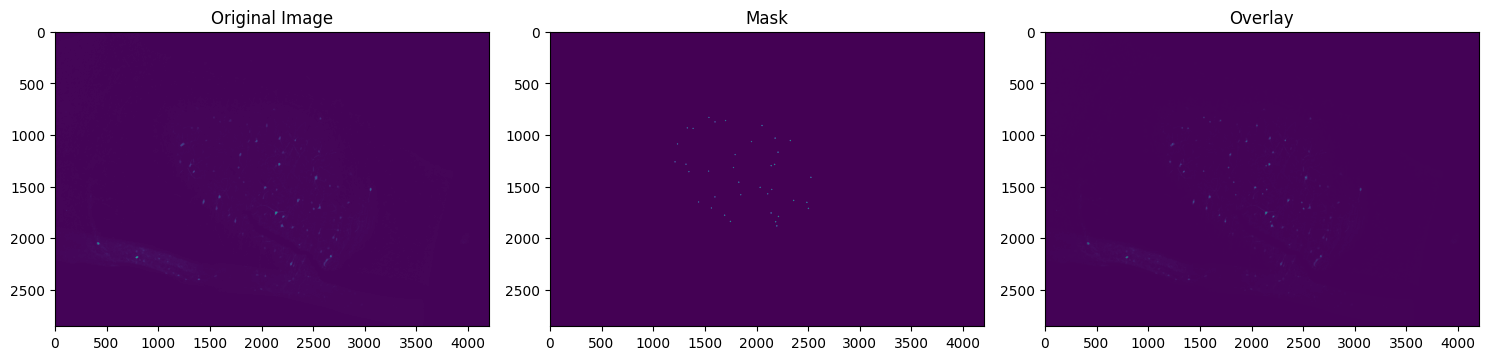

In [68]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.morphology import binary_dilation, ball

def create_mask_from_coordinates(image_shape, coordinates, radius=5, sigma=2):
    """
    从坐标点创建分割掩码
    
    参数:
    image_shape: 原始图像的形状
    coordinates: 坐标点数组 (N x 3)
    radius: 每个点扩展成球体的半径
    sigma: 高斯平滑的sigma值
    """
    # 创建空白掩码
    mask = np.zeros(image_shape, dtype=np.float32)
    
    # 将坐标点转换为整数
    coords = np.round(coordinates).astype(int)
    
    # 在每个坐标点位置标记为1
    for x, y, z in coords:
        # 确保坐标在图像范围内
        if (0 <= x < image_shape[0] and 
            0 <= y < image_shape[1] and 
            0 <= z < image_shape[2]):
            mask[x, y, z] = 1
    
    # 使用球形结构元素进行膨胀
    struct_element = ball(radius)
    mask = binary_dilation(mask, struct_element)
    
    # 可选：应用高斯平滑使边缘更自然
    mask = gaussian_filter(mask.astype(float), sigma)
    
    # 二值化
    mask = (mask > 0.5).astype(np.float32)
    
    return mask

# 为活体图像创建掩码
invivo_mask = create_mask_from_coordinates(
    scaled_invivo_image.shape, 
    scaled_in_vivo_coords,
    radius=5,  # 调整这个值以获得合适的掩码大小
    sigma=2    # 调整这个值以获得合适的边缘平滑度
)

# 为离体图像创建掩码
exvivo_mask = create_mask_from_coordinates(
    exvivo_image.shape,
    ex_vivo_coords,
    radius=5,
    sigma=2
)

# 可视化检查掩码效果
def visualize_mask(image, mask, slice_idx=None):
    if slice_idx is None:
        slice_idx = image.shape[0] // 2
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(image[slice_idx])
    plt.title('Original Image')
    
    plt.subplot(132)
    plt.imshow(mask[slice_idx])
    plt.title('Mask')
    
    plt.subplot(133)
    plt.imshow(image[slice_idx])
    plt.imshow(mask[slice_idx], alpha=0.3)
    plt.title('Overlay')
    
    plt.tight_layout()
    plt.show()

# 检查生成的掩码
visualize_mask(scaled_invivo_image, invivo_mask)
visualize_mask(exvivo_image, exvivo_mask,slice_idx=1)

# 现在你可以使用这些掩码替代原来的分割结果
im1_bi_happy = invivo_mask  # 用于 apply_deformable_2_binary
seg_cc_f_zstack = invivo_mask
seg_cc_f_nd2 = exvivo_mask


In [69]:
from scipy.ndimage import label

# 计算唯一区域的数量
def count_unique_regions(mask):
    labeled_mask, num_features = label(mask)
    return num_features

# 计算活体图像掩码中的唯一区域数量
num_invivo_regions = count_unique_regions(invivo_mask)
print("Unique regions in invivo mask:", num_invivo_regions)

# 计算离体图像掩码中的唯一区域数量
num_exvivo_regions = count_unique_regions(exvivo_mask)
print("Unique regions in exvivo mask:", num_exvivo_regions)

Unique regions in invivo mask: 37
Unique regions in exvivo mask: 37


### Wahba MRS

In [70]:
# 没有scal
# bhat = wahba(in_vivo_coords, ex_vivo_coords)  # transforms from source to target
# scale 之后
bhat = wahba(scaled_in_vivo_coords, ex_vivo_coords)

In [71]:
print(bhat)

[[ 9.99999986e-01  4.86583829e-05 -1.62775914e-04]
 [-6.98769546e-05  9.91114615e-01 -1.33010583e-01]
 [ 1.54857507e-04  1.33010592e-01  9.91114604e-01]
 [-8.65979241e-01  1.55617836e+02  1.18351644e+03]]


### Double ICP

In [72]:
# 没有scale
# tran, im1_wahba = run_doubleICP(invivo_image, exvivo_image, bhat, in_vivo_coords, ex_vivo_coords, max_correspondence_distance = 100)
# scale 之后
# tran 是 transofmration matrix
# im1_wahba 通过run_doubleICP 刚性变换（rotation, scale, shift)
# max_correspondence_distance 是最大对应点距离阈值

tran, im1_wahba = run_doubleICP(scaled_invivo_image, exvivo_image, bhat, scaled_in_vivo_coords, ex_vivo_coords, max_correspondence_distance = 100)

In [73]:
# ICP debug
print("ICP Transformation:")
print("Rotation part:\n", tran[:3,:3])
print("Translation part:\n", tran[:3,3])
print("Scale:", np.cbrt(np.linalg.det(tran[:3,:3])))

ICP Transformation:
Rotation part:
 [[ 9.86712582e-01 -6.52557603e-06  1.76326501e-06]
 [ 6.51863492e-06  9.86705046e-01  3.85631350e-03]
 [-1.78875509e-06 -3.85631348e-03  9.86705046e-01]]
Translation part:
 [1.21699530e-02 1.35951566e+01 2.98208458e+01]
Scale: 0.9867125815291987


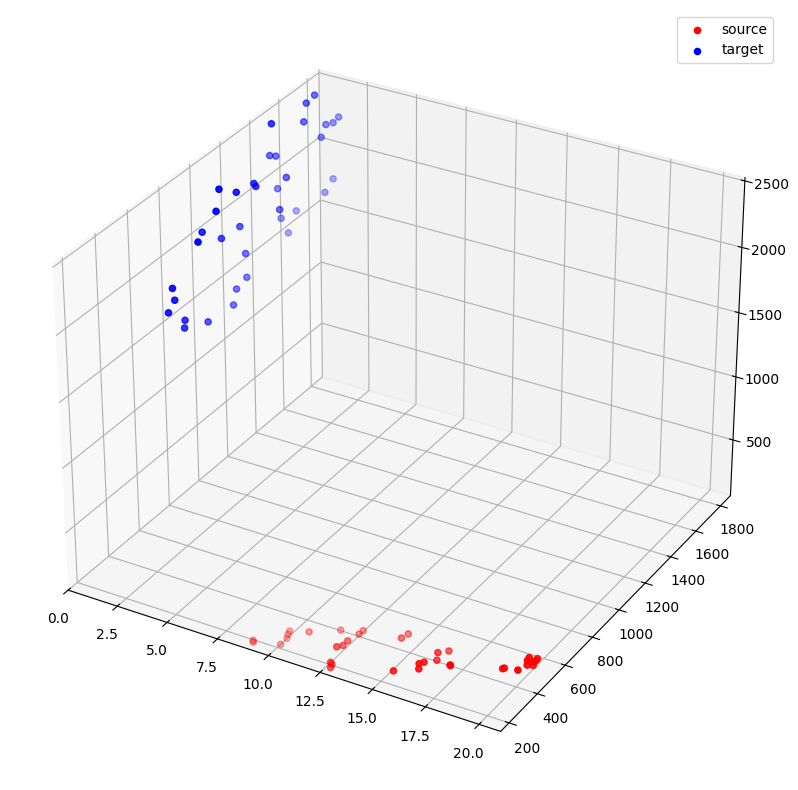

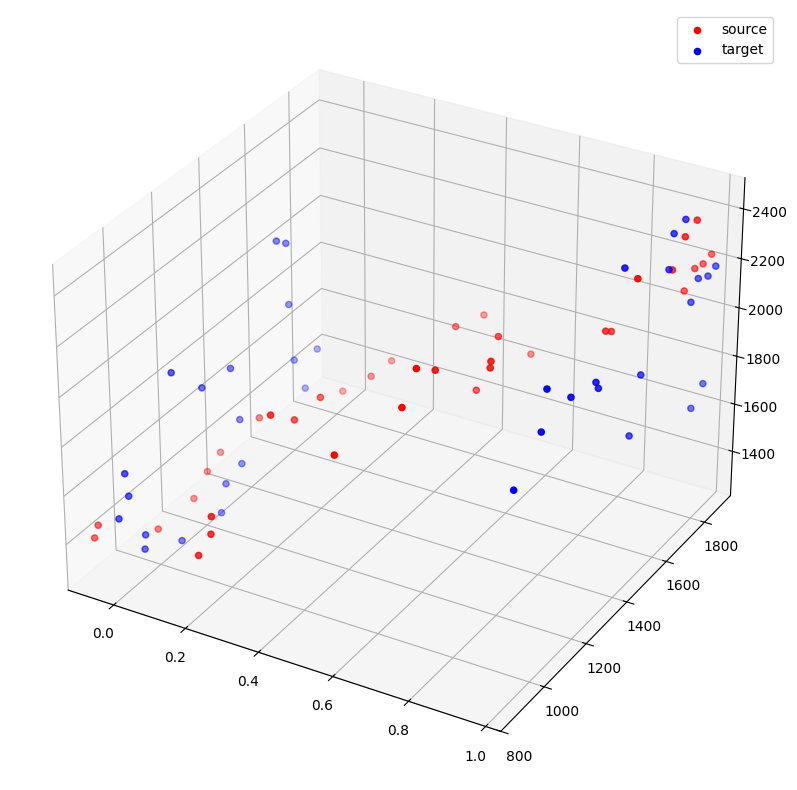

In [74]:
# ICP Debug

# def visualize_point_matches(source_points, target_points):
#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(source_points[:,0], source_points[:,1], source_points[:,2], c='r', label='source')
#     ax.scatter(target_points[:,0], target_points[:,1], target_points[:,2], c='b', label='target')
#     plt.legend()
#     plt.show()

def visualize_point_matches(source_points, target_points):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 设定固定的轴范围
    x_min, x_max = min(source_points[:,0].min(), target_points[:,0].min()), max(source_points[:,0].max(), target_points[:,0].max())
    y_min, y_max = min(source_points[:,1].min(), target_points[:,1].min()), max(source_points[:,1].max(), target_points[:,1].max())
    z_min, z_max = min(source_points[:,2].min(), target_points[:,2].min()), max(source_points[:,2].max(), target_points[:,2].max())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    
    ax.scatter(source_points[:,0], source_points[:,1], source_points[:,2], c='r', label='source')
    ax.scatter(target_points[:,0], target_points[:,1], target_points[:,2], c='b', label='target')
    plt.legend()
    plt.show()

# 查看原始匹配点
visualize_point_matches(in_vivo_coords, ex_vivo_coords)

# 查看变换后的点
transformed_points = np.c_[scaled_in_vivo_coords, np.ones((scaled_in_vivo_coords.shape[0],1))] @ bhat
visualize_point_matches(transformed_points, ex_vivo_coords)

In [75]:
total_R, total_shift, total_scale = get_final_transformation(tran,bhat) 

In [76]:
# print out the final results. 
print('rotation matrix:\n',total_R)
print(f'scale:\n{total_scale}')
print('shift:\n',total_shift)
print(f'euler (radiant):\n{rotationMatrixToEulerAngles(total_R/total_scale)}')
print(f'euler (degree):\n{angles(rotationMatrixToEulerAngles(total_R/total_scale))}')

rotation matrix:
 [[ 9.86712567e-01  5.39023917e-05 -1.62588213e-04]
 [-7.56505969e-05  9.77424861e-01 -1.35064262e-01]
 [ 1.53679478e-04  1.35064272e-01  9.77424850e-01]]
scale:
0.9867125815291993
shift:
 [-8.41231302e-01  1.71708065e+02  1.19700238e+03]
euler (radiant):
[-7.66693355e-05 -1.55748980e-04  1.37314205e-01]
euler (degree):
[-4.000e-03 -9.000e-03  7.868e+00]


### Apply Rigid Transformation

In [77]:
## 原始代码
# im1_happy = apply_total_R(z_f,nd2_f, total_R, total_shift)
# im1_bi_happy = apply_doubleICP_2_binary(seg_cc_f_zstack,seg_cc_f_nd2,total_R,total_shift)

## scale 后
# 如果是原始图像
# im1_happy = apply_total_R(invivo_image, exvivo_image, total_R, total_shift)
im1_happy= apply_total_R(scaled_invivo_image, exvivo_image, total_R, total_shift)

# 如果是二值图像 (segmentation)
im1_bi_happy = apply_doubleICP_2_binary(seg_cc_f_zstack,seg_cc_f_nd2,total_R,total_shift)

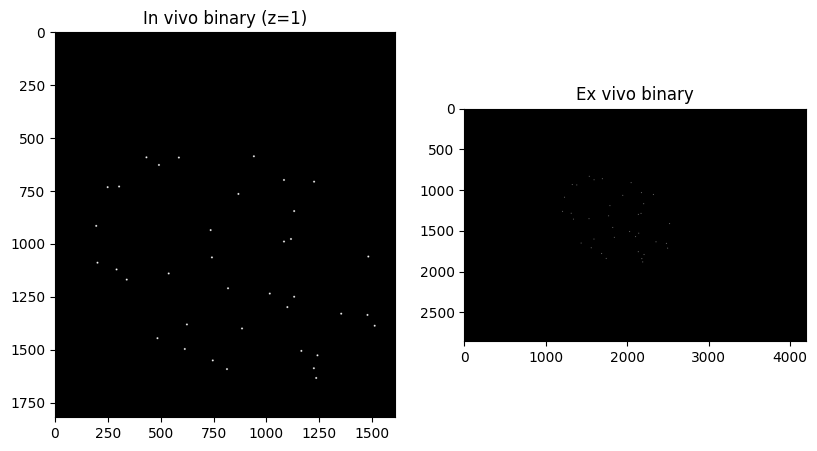

In [78]:
# Visualize original binary images first (taking middle z-slice)
z_slice =  1
z_slice_ex = 0

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(seg_cc_f_zstack[z_slice], cmap='gray')
plt.title('In vivo binary (z=%d)' % z_slice)
plt.subplot(132)
plt.imshow(seg_cc_f_nd2[z_slice_ex], cmap='gray')
plt.title('Ex vivo binary')
plt.show()

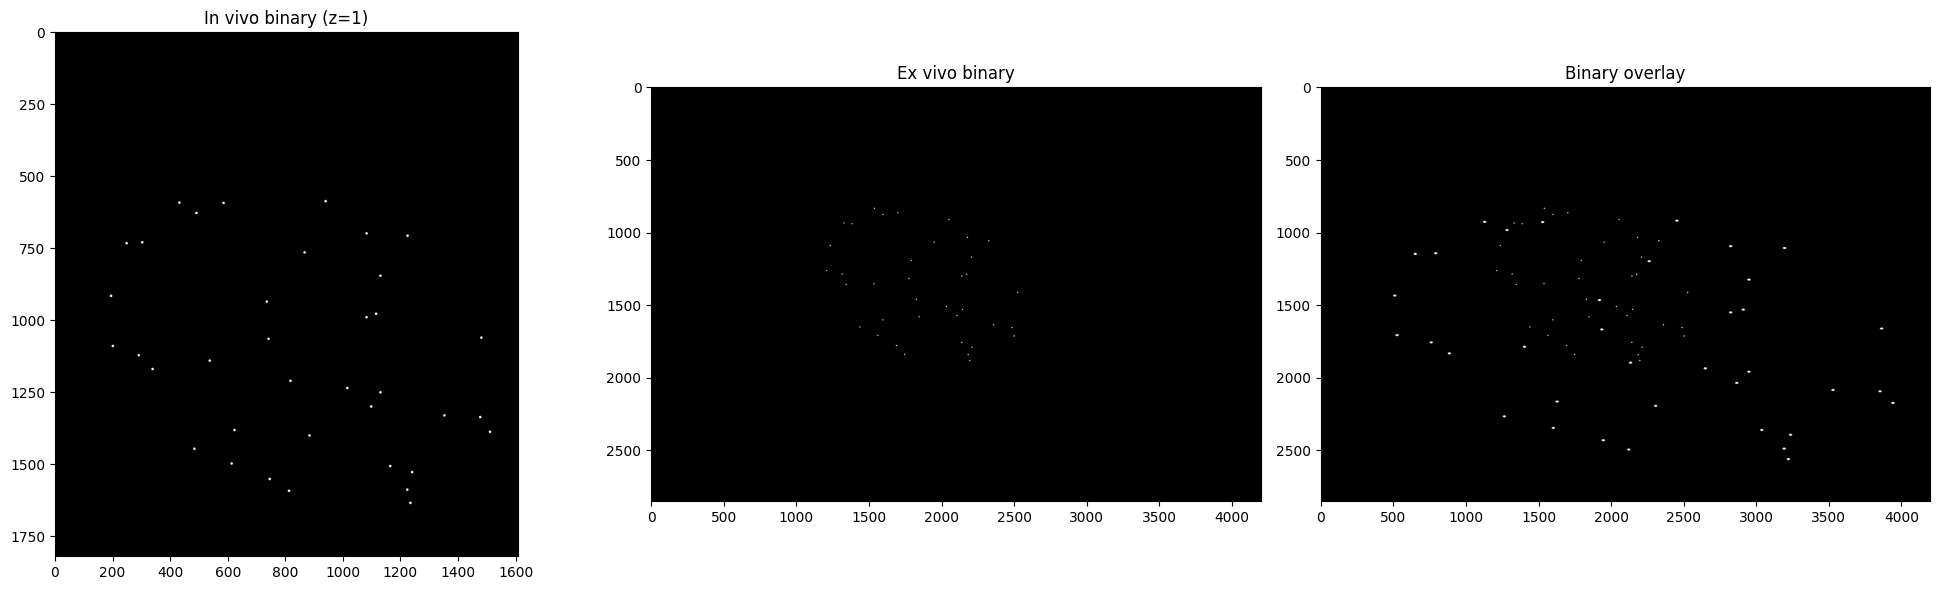

In [79]:
# 获取目标尺寸（较大图像的尺寸）
target_shape = seg_cc_f_nd2[z_slice_ex].shape  # (2851, 4201)

# 将较小的图像放大到目标尺寸，使用最近邻插值
seg_cc_f_zstack_resized = cv2.resize(seg_cc_f_zstack[z_slice], 
                                    (target_shape[1], target_shape[0]),  # cv2.resize需要(width, height)
                                    interpolation=cv2.INTER_NEAREST)

# 显示结果
plt.figure(figsize=(20,6))

# 显示原始的体内图像
plt.subplot(131)
plt.imshow(seg_cc_f_zstack[z_slice], cmap='gray')
plt.title('In vivo binary (z=%d)' % z_slice)

# 显示体外图像
plt.subplot(132)
plt.imshow(seg_cc_f_nd2[z_slice_ex], cmap='gray')
plt.title('Ex vivo binary')

# 显示叠加结果
plt.subplot(133)
plt.imshow(seg_cc_f_zstack_resized + seg_cc_f_nd2[z_slice_ex], cmap='gray')
plt.title('Binary overlay')

plt.tight_layout()
plt.show()

### Deformable

iteration 0...


/scratch/jl10897/multimodal_image_registration/functions/iterive_non_rigid.py:103: UserWarning: Could not determine RMS error between images with the normalized average intensities 116534032.83264744 and 0.0. Either the reference or moving image may be empty.
  shift,_,_ = phase_cross_correlation(im1_t_f, im2_t_f)
/scratch/jl10897/multimodal_image_registration/functions/cellregister.py:31: RuntimeWarning: invalid value encountered in divide
  out = out/np.std(foo)
/scratch/jl10897/multimodal_image_registration/functions/iterive_non_rigid.py:103: UserWarning: Could not determine RMS error between images with the normalized average intensities 140162127.94650212 and 0.0. Either the reference or moving image may be empty.
  shift,_,_ = phase_cross_correlation(im1_t_f, im2_t_f)
/scratch/jl10897/multimodal_image_registration/functions/iterive_non_rigid.py:103: UserWarning: Could not determine RMS error between images with the normalized average intensities 147501805.75171465 and 0.0. Either

iteration 5...
iteration 10...
iteration 15...


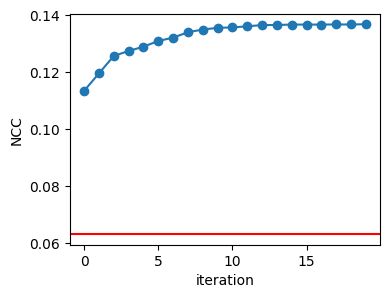

In [80]:
from functions.iterive_non_rigid import *
# img_de,z_de,ncc_list,vec_field_smooth_list = learn_and_apply_deformable(im1_happy,exvivo_image,vec_ds=3)
img_de,z_de,ncc_list,vec_field_smooth_list = learn_and_apply_deformable(im1_happy,exvivo_image,vec_ds=3,iterations=20)
# img_de, z_de, ncc_list, vec_field_smooth_list = learn_and_apply_deformable(im1_wahba, exvivo_image, vec_ds)

### Visualization and Evaluation

Exvivo image shape: (23, 2851, 4201)
Resized z_de shape: (23, 2851, 4201)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004711858292177998..10.0].


([], [])

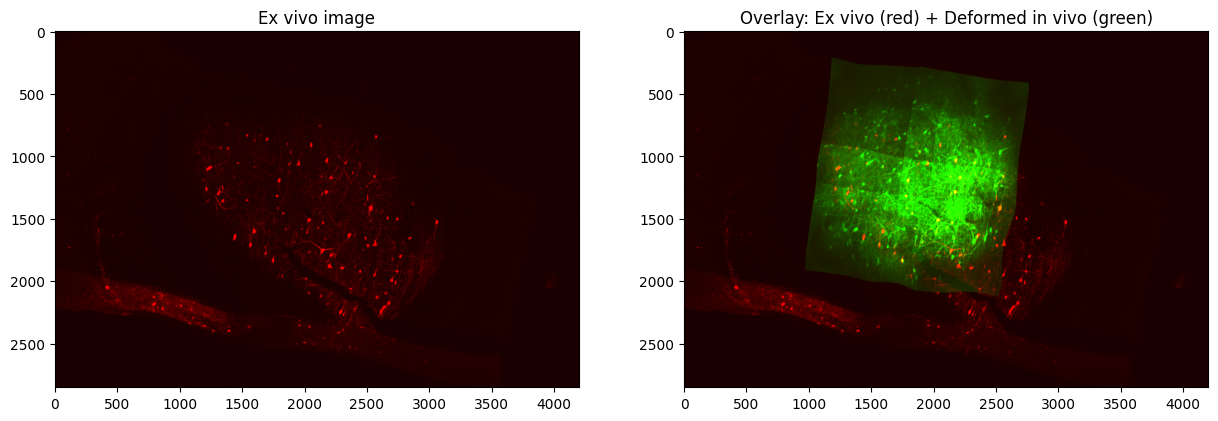

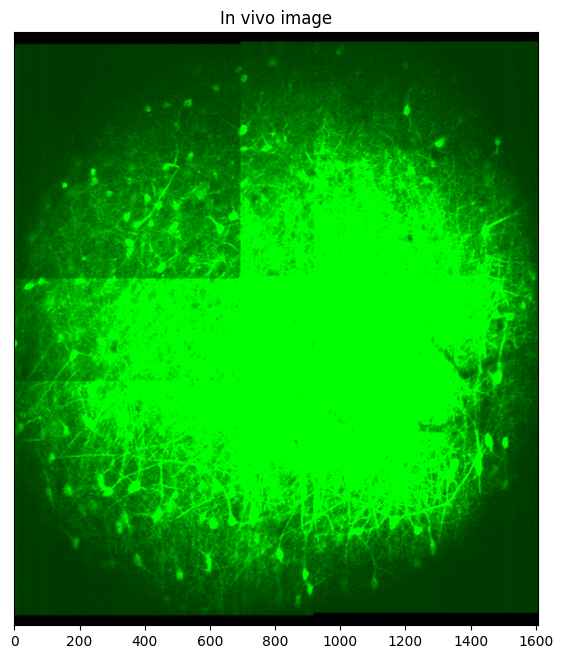

In [81]:
# img_de is the deformed in vivo image after non-rigid registration
# Here we visualize:
# 1. Original ex vivo image
# 2. Overlay of ex vivo (red) and deformed in vivo (green) to check registration
# 3. Original in vivo image

target_shape = exvivo_image.shape  # 使用完整的shape，包括所有维度
z_de_resized = resize(z_de, target_shape, preserve_range=True)
img_de_resized = resize(img_de, target_shape, preserve_range=True)

# 验证尺寸
print("Exvivo image shape:", exvivo_image.shape)
print("Resized z_de shape:", z_de_resized.shape)

scl_1 = 0.1  # scaling factor for ex vivo image visualization
scl_2 = 0.2  # scaling factor for in vivo image visualization

# 原来visualize 的是 exvivo image, exvivo image 和 deformed invivo image 叠加 还有 invivo image

plt.figure(figsize=(23,11))
plt.subplot(1,3,1)
plt.imshow(gray2RGB(exvivo_image, col='r', scl=scl_1))
plt.savefig(os.path.join(output_folder, 'Ex Vivo.png'))
plt.title('Ex vivo image')


plt.subplot(1,3,2) 
plt.imshow(gray2RGB(exvivo_image, col='r', scl=scl_1) + 
         gray2RGB(img_de_resized, col='g', scl=scl_2))
plt.title('Overlay: Ex vivo (red) + Deformed in vivo (green)')
plt.savefig(os.path.join(output_folder, 'Overlay.png'))


plt.subplot(1,3,3)
plt.imshow(gray2RGB(scaled_invivo_image, col='g', scl=scl_1))
plt.title('In vivo image')
plt.savefig(os.path.join(output_folder, 'In Vivo.png'))

plt.yticks([])



In [82]:
# first we apply the non-rigid transformation to the binary image too.
z_bi_de = apply_deformable_2_binary(im1_happy,im1_bi_happy,
                                    seg_cc_f_zstack,seg_cc_f_nd2,
                                    vec_ds,vec_field_smooth_list)

# then count the number of matchings. 
# 用的是deformable 之后的in_vivo_segmentation 和 exvivo_segmentation 去计算细胞的质心并寻找最近的细胞配对，来分析registration 的效果
cc_im1,cc_im2,closest_pair,z_cent_new,num_pairs = count_cell_matching(z_bi_de, seg_cc_f_nd2)

***FOUND PAIRS:*** 26


In [84]:
data_to_save = {
    'img_de': img_de,
    'z_de': z_de,
    'ncc_list': ncc_list,
    'vec_field_smooth_list': vec_field_smooth_list,
    'z_bi_de': z_bi_de,
    'seg_cc_f_nd2': seg_cc_f_nd2,
    'num_pairs': num_pairs
}


output_file = output_folder + '/results.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(data_to_save, f)




In [85]:
try:
    with open(output_file, 'rb') as f:
        look = pickle.load(f)
except Exception as e:
    print(f"Error reading pickle file: {e}")



{'img_de': array([[[-0.,  0.,  0., ...,  0.,  0.,  0.],
        [-0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[-0., -0.,  0., ...,  0.,  0.,  0.],
        [-0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[-0., -0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[-0., -0., -0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0

In [86]:
look.keys()

dict_keys(['img_de', 'z_de', 'ncc_list', 'vec_field_smooth_list', 'z_bi_de', 'seg_cc_f_nd2', 'num_pairs'])